In [2]:
import sys
sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")
#sys.path.insert(0, r'/home/pirwin/Git/HelperPI')

import HelperPI
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sts
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score, matthews_corrcoef, make_scorer, classification_report
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [3]:
helper = HelperPI.Helper()

INFO:root:Initializing...


In [4]:
#sql = helper.getSQL(r"C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\TAB_MODELING.sql")

In [5]:
#base, dtypesdf = helper.readData(sql)
base = pd.read_csv(r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\tab_model.csv', parse_dates=['DATE_VALUE'])
#base = pd.read_csv(r'/home/pirwin/Git/IPy_Notebooks/SQL/tab_model.csv',parse_dates=['DATE_VALUE'])
dtypes = helper.getDtypes(base)

INFO:root:Getting data types...


                  Count     Column Type
0            DATE_VALUE  datetime64[ns]
1                RECORD          object
2            MEDHINC_CY         float64
3             MEDAGE_CY         float64
4            CLOSEST_BP         float64
5           CLOSEST_CAB         float64
6     MALES_IN_HOUSHOLD           int64
7   FEMALES_IN_HOUSHOLD           int64
8      REWARDS_CUSTOMER           int64
9      DAYS_AS_CUSTOMER           int64
10   TOTAL_TRANSACTIONS           int64
11     REW_TRANSACTIONS           int64
12          TOTAL_SPEND         float64
13  DAYS_SINCE_PURCHASE           int64
14     TARGET_VALUE12MO         float64
15  TARGET_PURCH_NEXT15           int64


### Imputing missing then Splitting the data for train and test using helper application

In [29]:
collist = ['MEDHINC_CY','MEDAGE_CY','CLOSEST_BP','MALES_IN_HOUSHOLD','FEMALES_IN_HOUSHOLD','REWARDS_CUSTOMER',
          'DAYS_AS_CUSTOMER','TOTAL_TRANSACTIONS','REW_TRANSACTIONS','TOTAL_SPEND','DAYS_SINCE_PURCHASE']
X = base[collist]
y = base['TARGET_PURCH_NEXT15']


### Determination of missing values

In [30]:
missing_df = X.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / X.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.01]

,column_name,missing_count,missing_ratio
0,MEDHINC_CY,3792,0.03792
1,MEDAGE_CY,3792,0.03792


In [64]:

imr = Imputer(missing_values='NaN',strategy='median',axis=0)
imr = imr.fit(X)
imputed_data = pd.DataFrame(imr.transform(X.values), columns = collist)

for var in collist:
    coef, pval = stats.pearsonr(imputed_data[var].as_matrix(), y.as_matrix())
    
    print(var + ' Coef: %.2f  pval:  %.4f' % (coef, pval))

    
collist2 = ['CLOSEST_BP','MALES_IN_HOUSHOLD','REWARDS_CUSTOMER',
          'DAYS_AS_CUSTOMER','TOTAL_TRANSACTIONS','REW_TRANSACTIONS','TOTAL_SPEND','DAYS_SINCE_PURCHASE']

imputed_data2 = imputed_data[collist2]

imputed_data2.head()

MEDHINC_CY Coef: -0.01  pval:  0.1072
MEDAGE_CY Coef: 0.03  pval:  0.0000
CLOSEST_BP Coef: -0.01  pval:  0.0001
MALES_IN_HOUSHOLD Coef: 0.18  pval:  0.0000
FEMALES_IN_HOUSHOLD Coef: 0.04  pval:  0.0000
REWARDS_CUSTOMER Coef: 0.34  pval:  0.0000
DAYS_AS_CUSTOMER Coef: 0.06  pval:  0.0000
TOTAL_TRANSACTIONS Coef: 0.30  pval:  0.0000
REW_TRANSACTIONS Coef: 0.27  pval:  0.0000
TOTAL_SPEND Coef: 0.36  pval:  0.0000
DAYS_SINCE_PURCHASE Coef: -0.38  pval:  0.0000


,CLOSEST_BP,MALES_IN_HOUSHOLD,REWARDS_CUSTOMER,DAYS_AS_CUSTOMER,TOTAL_TRANSACTIONS,REW_TRANSACTIONS,TOTAL_SPEND,DAYS_SINCE_PURCHASE
0,47.97,0.0,0.0,3265.0,2.0,0.0,500.43,3057.0
1,71.22,1.0,0.0,3351.0,6.0,0.0,322.96,178.0
2,38.96,1.0,1.0,2672.0,5.0,4.0,127.18,2464.0
3,23.86,0.0,0.0,1574.0,3.0,1.0,233.94,104.0
4,73.31,1.0,1.0,3782.0,11.0,7.0,1248.58,730.0


In [65]:
train_X, test_X, train_y, test_y = helper.splitData2(imputed_data2, y, 0.5)

train_X = pd.DataFrame(train_X, columns=collist2)
test_X = pd.DataFrame(test_X, columns=collist2)

In [66]:
train_X.head()

,CLOSEST_BP,MALES_IN_HOUSHOLD,REWARDS_CUSTOMER,DAYS_AS_CUSTOMER,TOTAL_TRANSACTIONS,REW_TRANSACTIONS,TOTAL_SPEND,DAYS_SINCE_PURCHASE
24341,3.99,0.0,1.0,1045.0,2.0,1.0,104.94,726.0
67534,8.99,1.0,1.0,3747.0,22.0,12.0,1397.47,199.0
35080,64.42,0.0,0.0,1655.0,2.0,0.0,233.75,1166.0
4828,11.81,0.0,0.0,945.0,2.0,0.0,144.19,92.0
59259,92.59,1.0,1.0,2668.0,4.0,4.0,870.94,2005.0


In [ ]:
#sns.pairplot(train_X)
#sns.plt.savefig('Scattermatrix.png')
#plt.show()

In [67]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
train_X_std = pd.DataFrame(stdsc.fit_transform(train_X), columns=collist2)
test_X_std = pd.DataFrame(stdsc.fit_transform(test_X), columns=collist2)

#sns.pairplot(train_X_std)
#sns.plt.savefig('Scattermatrix.png')
#plt.show()

 1) DAYS_SINCE_PURCHASE            0.275578
 2) TOTAL_SPEND                    0.178210
 3) DAYS_AS_CUSTOMER               0.137304
 4) CLOSEST_BP                     0.134193
 5) TOTAL_TRANSACTIONS             0.131576
 6) REW_TRANSACTIONS               0.094983
 7) REWARDS_CUSTOMER               0.026242
 8) MALES_IN_HOUSHOLD              0.021913


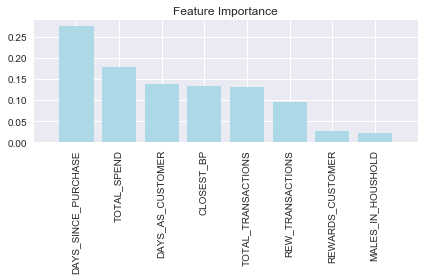

In [68]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = np.asarray(collist2)

forests = RandomForestClassifier(n_estimators=1000,
                                random_state=0,
                                n_jobs=-1)
forests.fit(train_X_std, train_y)
importances = forests.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(train_X_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]],
                                      importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(train_X_std.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(train_X_std.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, train_X_std.shape[1]])
plt.tight_layout()
plt.show()

### XGBoost Model

In [ ]:
import xgboost as xgb

xgb_params = {
    'booster': 'gbtree',
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'silent': 0,
    'seed' : 0,
    'eval_metric':'error',
    'max_delta_step' : 1
}
dtrain = xgb.DMatrix(train_X_std, train_y, feature_names=train_X.columns.values)
d_test = xgb.DMatrix(test_X_std, test_y, feature_names=test_X.columns.values)
model = xgb.train(xgb_params, dtrain, evals=[(d_test, "eval")], 
                  num_boost_round=1000, early_stopping_rounds=100)



fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

### Sklearn API version

[0]	validation_0-auc:0.686	validation_1-auc:0.665756
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.7018	validation_1-auc:0.681969
[2]	validation_0-auc:0.74452	validation_1-auc:0.727804
[3]	validation_0-auc:0.752438	validation_1-auc:0.736261
[4]	validation_0-auc:0.755063	validation_1-auc:0.739201
[5]	validation_0-auc:0.760164	validation_1-auc:0.74502
[6]	validation_0-auc:0.763063	validation_1-auc:0.747877
[7]	validation_0-auc:0.768534	validation_1-auc:0.756772
[8]	validation_0-auc:0.770506	validation_1-auc:0.758567
[9]	validation_0-auc:0.771892	validation_1-auc:0.760054
[10]	validation_0-auc:0.771942	validation_1-auc:0.760767
[11]	validation_0-auc:0.780728	validation_1-auc:0.769911
[12]	validation_0-auc:0.7814	validation_1-auc:0.770927
[13]	validation_0-auc:0.793316	validation_1-auc:0.78209
[14]	validation_0-auc:0.79627	validation_1-auc:0.785995
[15]	val

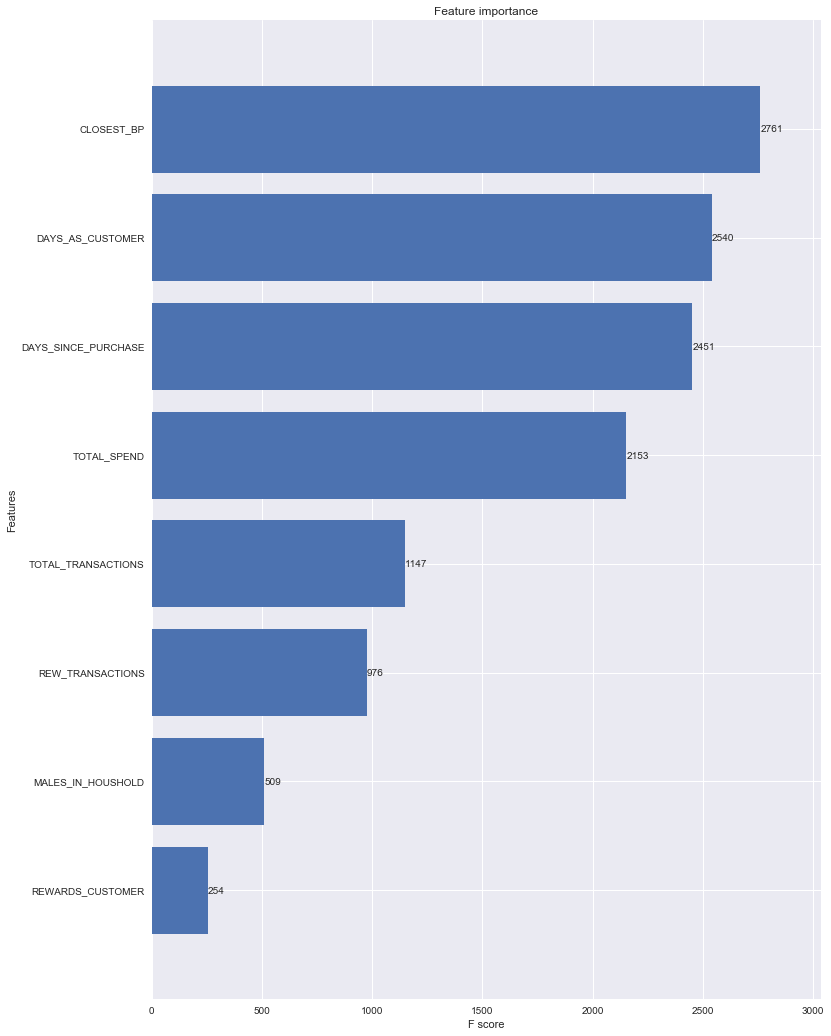

In [72]:
mod = xgb.XGBClassifier(max_depth=8, subsample=0.7, colsample_bytree=0.7, objective='binary:logistic', learning_rate=0.05, 
                       max_delta_step=0.5, seed=0)
fitted = mod.fit(train_X_std, train_y, 
                 eval_set=[(train_X_std, train_y), (test_X_std, test_y)], 
                 eval_metric='auc',
                 early_stopping_rounds=100,
                 verbose=True)

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(fitted, height=0.8, ax=ax)
plt.show()

### Confusion matrix and ROC Curve

Accuracy: 86.44%


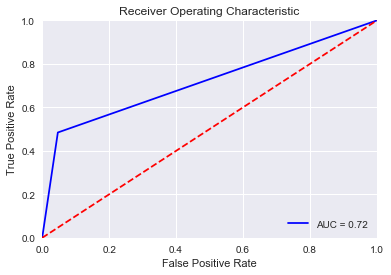

             precision    recall  f1-score   support

          0       0.89      0.95      0.92     40529
          1       0.71      0.48      0.58      9471

avg / total       0.85      0.86      0.85     50000



In [75]:
#from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
pred_y = fitted.predict(test_X_std)




predictions = [round(value) for value in pred_y]
# evaluate predictions
accuracy = accuracy_score(test_y, pred_y)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(classification_report(test_y, predictions))


### Parameter Tuning Version

In [ ]:
def modelfit(alg, dtrain, dlabels, feature_names, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=dlabels.values, feature_names = feature_names)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])

    alg.fit(dtrain, dlabels, eval_metric='auc')

    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dlabels.values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dlabels.values, dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    
    

In [ ]:
xgb1 = xgb.XGBClassifier(
    learning_rate = 0.07,
    n_estimators = 1000,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    seed = 27)

modelfit(xgb1, train_X_std, train_y, collist)

In [ ]:
auc_weighted = make_scorer(roc_auc_score, average='weighted')
auc_weighted

In [ ]:
param_test1 = {
    'max_depth':list(range(3,10,2)),
    'min_child_weight':list(range(1,6,2))
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=300, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test1, scoring='f1', iid=False, cv=5)

gsearch1.fit(train_X.values, train_y.values)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
# max_depth = 5

param_test2 = {
    'min_child_weight':[2,3,4,5],
    'max_depth':[2,3,4,5]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.07, n_estimators=300, max_depth=4,
     min_child_weight=4, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test2, scoring ='f1', iid=False, cv=5)

gsearch2.fit(train_X.values, train_y.values)

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
#max_depth = 4
#min_child_weight = 4

param_test3 = {
    'gamma':[i/10.0 for i in range(0, 5)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.07, n_estimators=300, max_depth=4,
     min_child_weight=4, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test3, scoring = 'f1', iid=False, cv=5)

gsearch3.fit(train_X.values, train_y.values)

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
xgb2 = xgb.XGBClassifier(
    learning_rate = 0.07,
    n_estimators = 1000,
    max_depth = 4,
    min_child_weight = 4,
    gamma = 0.4,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    seed = 27)

modelfit(xgb2, train_X_std, train_y, collist)




In [ ]:
#max_depth = 4
#min_child_weight = 4
#gamma = 0.4

param_test4 = {
    'subsample':[i/10.0 for i in range(3, 10)],
    'colsample_bytree':[i/10.0 for i in range(4, 10)]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.07, n_estimators=140, max_depth=4,
     min_child_weight=4, gamma=0.4, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', scale_pos_weight=1, seed=27),
     param_grid = param_test4, scoring = 'f1', iid=False, cv=5)

gsearch4.fit(train_X.values, train_y.values)

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
#max_depth = 4
#min_child_weight = 4
#gamma = 0.4
#subsample = 0.4
#colsample_bytree = 0.5

param_test5 = {

    'colsample_bytree':[i/100.0 for i in range(30, 65, 5)],
    'subsample':[i/100 for i in range(30,65,5)]
}

gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.07, n_estimators=140, max_depth=4,
     min_child_weight=4, gamma=0.4, subsample=0.4, colsample_bytree=0.5,
     objective= 'binary:logistic', scale_pos_weight=1, seed=27),
     param_grid = param_test5, scoring = 'f1', iid=False, cv=5)

gsearch5.fit(train_X.values, train_y.values)

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
#max_depth = 4
#min_child_weight = 4
#gamma = 0.4
#subsample = 0.4
#colsample_bytree = 0.5

param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.07, n_estimators=300, max_depth=4,
     min_child_weight=4, gamma=0.4, subsample=0.4, colsample_bytree=0.5,
     objective= 'binary:logistic', scale_pos_weight=1, seed=27),
     param_grid = param_test6, scoring = 'f1', iid=False, cv=5)

gsearch6.fit(train_X.values, train_y.values)

gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
#max_depth = 4
#min_child_weight = 4
#gamma = 0.4
#subsample = 0.4
#colsample_bytree = 0.5
#reg_alpha = 100

param_test7 = {
    'reg_alpha':[80, 90, 100, 110, 120, 130, 140]
}

gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.07, n_estimators=300, max_depth=4,
     min_child_weight=4, gamma=0.4, subsample=0.4, colsample_bytree=0.5,
     objective= 'binary:logistic', scale_pos_weight=1, seed=27),
     param_grid = param_test7, scoring = 'f1', iid=False, cv=5)

gsearch7.fit(train_X.values, train_y.values)

gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
xgb3 = xgb.XGBClassifier(
    learning_rate = 0.01,
    n_estimators = 1000,
    max_depth = 4,
    min_child_weight = 4,
    gamma = 0.4,
    subsample = 0.4,
    colsample_bytree = 0.55,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    reg_alpha=100,
    seed = 27)

modelfit(xgb3, train_X_std, train_y, collist)

In [ ]:
tuned_model = xgb.XGBClassifier(learning_rate = 0.01,
                        n_estimators = 1000,
                        max_depth = 4,
                        min_child_weight = 4,
                        gamma = 0.4,
                        subsample = 0.4,
                        colsample_bytree = 0.5,
                        objective = 'binary:logistic',
                        scale_pos_weight = 1,
                        reg_alpha=100,
                        seed = 27)
fitted = tuned_model.fit(train_X_std, train_y, 
                 eval_set=[(train_X_std, train_y), (test_X_std, test_y)], 
                 eval_metric='error',
                 early_stopping_rounds=50,
                 verbose=True)

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(fitted, height=0.8, ax=ax)
plt.show()

In [ ]:
pred_y = fitted.predict(test_X_std)

predictions = [round(value) for value in pred_y]
# evaluate predictions
accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###  Alternate Parameter tuning - only for fast running algorithms

In [ ]:

tuned_parameters = [{
    'learning_rate':[0.1],
    'n_estimators': [150],
    'objective':['binary:logistic'],
    'scale_pos_weight':[1],
    'max_depth':list(range(3,10,2)),
    'min_child_weight':list(range(1,6,2)),
    'subsample':[i/10.0 for i in range(3, 10)],
    'colsample_bytree':[i/10.0 for i in range(4, 10)],
    'gamma':[i/10.0 for i in range(0, 5)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    
}]
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(xgb.XGBClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(train_X_std, train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_y, clf.predict(test_X_std)
    print(classification_report(y_true, y_pred))
    print()

### sklearn mlpclassifier

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:

clf = MLPClassifier(activation='logistic', early_stopping=True, learning_rate='adaptive', learning_rate_init=.0001, 
                    verbose=True, validation_fraction=0.1)
clf.fit(train_X_std, train_y)

In [ ]:
pred_y = clf.predict(test_X_std)

accuracy = accuracy_score(test_y, pred_y)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


fpr, tpr, _ = roc_curve(test_y, pred_y)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
clf.predict_proba(test_X_std)

In [ ]:
np.all(np.isfinite(test_X))

In [ ]:
np.any(np.isnan(test_X))